# Uso de docTR

# Instalación



## Instalación del paquete original



In [1]:
# TensorFlow
# !pip install python-doctr[tf,viz]

# PyTorch
# First we have to uninstall the preinstalled tensorflow version if we want to work with PyTorch as backend
# because the env variables USE_TORCH=1 / USE_TF=1 doesn't have an effect in Colab
#!pip uninstall -y tensorflow
#!pip install python-doctr[torch,viz]

## Intalación de mi versión

He hecho un fork del proyecto original para mejorar como se agrupan los bloques para obtener los parrafos correctos del texto

In [ ]:
# Install the most up-to-date version from GitHub

# TensorFlow
# !pip install python-doctr[tf,viz]@git+https://github.com/mindee/doctr.git

# PyTorch
# First we have to uninstall the preinstalled tensorflow version if we want to work with PyTorch as backend
# because the env variables USE_TORCH=1 / USE_TF=1 doesn't have an effect in Colab
# !pip uninstall -y tensorflow # Only if using Colab with PyTorch backend
!pip install python-doctr[torch,viz]@git+https://github.com/BlaiPuchol/doctr.git

# Dependencias

Algunas fuentes para la reconstrucción

In [3]:
# Install some free fonts for result rendering
!apt-get install fonts-freefont-ttf -y


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from doctr.io import DocumentFile
from doctr.models import ocr_predictor

docTR ejecuta, en segundo plano, modelos de aprendizaje profundo para realizar las diferentes tareas que soporta. Cuenta con modelos con frameworks muy populares para lograr la máxima compatibilidad (se puede usar tanto con [PyTorch](https://pytorch.org/) o [TensorFlow](https://www.tensorflow.org/) sin notar ninguna diferencia). Se puede seleccionar tanto el modelo de detección como el modelo de reconocimiento. Todo esto se encapsula en un objeto `Predictor`, que se encargará del preprocesamiento, la inferencia del modelo y el posprocesamiento. 

In [2]:
# Instantiate a pretrained model
predictor = ocr_predictor('fast_base', # Text Detection
                          'crnn_vgg16_bn', # Text Recognition
                          pretrained=True,
                          assume_straight_pages=True,
                          resolve_lines=True,
                          resolve_blocks=True,
                          disable_page_orientation=True, # This will only have an effect with assume_straight_pages=False and/or straighten_pages=True and/or detect_orientation=True.
                          disable_crop_orientation=True, # This will only have an effect with assume_straight_pages=False and/or straighten_pages=True.
                          paragraph_break=1.6, # Paragraph break threshold, in relation to the height of the text line bounding box. 
                          ) #.cuda().half() # Use .cpu() if you don't have a GPU

Por defecto, el modelo de PyTorch proporciona una descripción visual clara del modelo, lo cual resulta útil para depurar o para saber qué se acaba de crear. También hay una función similar para el backend de TensorFlow para que no se pierda esta útil ayuda.

Profundicemos en este modelo 🕵

In [3]:
# Display the architecture
print(predictor)

OCRPredictor(
  (det_predictor): DetectionPredictor(
    (pre_processor): PreProcessor(
      (resize): Resize(output_size=(1024, 1024), interpolation='bilinear', preserve_aspect_ratio=True, symmetric_pad=True)
      (normalize): Normalize(mean=(0.798, 0.785, 0.772), std=(0.264, 0.2749, 0.287))
    )
    (model): FAST()
  )
  (reco_predictor): RecognitionPredictor(
    (pre_processor): PreProcessor(
      (resize): Resize(output_size=(32, 128), interpolation='bilinear', preserve_aspect_ratio=True, symmetric_pad=False)
      (normalize): Normalize(mean=(0.694, 0.695, 0.693), std=(0.299, 0.296, 0.301))
    )
    (model): CRNN(
      (feat_extractor): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=

Aquí inspeccionamos el objeto más complejo (y de alto nivel) de la API de docTR: un predictor de OCR. Dado que docTR logra el OCR localizando primero los elementos textuales (Detección de Texto) y luego extrayendo el texto correspondiente de cada ubicación (Reconocimiento de Texto), el Predictor de OCR encapsula dos subpredictores: uno para la detección de texto y otro para el reconocimiento de texto.

## Inferencia básica

Seleccionamos el archivo a extraer el texto. Puede ser tanto una imagen como un documento.

In [4]:
# Read the file
doc = DocumentFile.from_images("167.jpg")
print(f"Number of pages: {len(doc)}")

Number of pages: 1


Y procesamos el archivo

In [5]:
result = predictor(doc)

## Visualización de la predicción

Los datos obtenidos se pueden visualizar de muchas formas:

### En la propia imagen

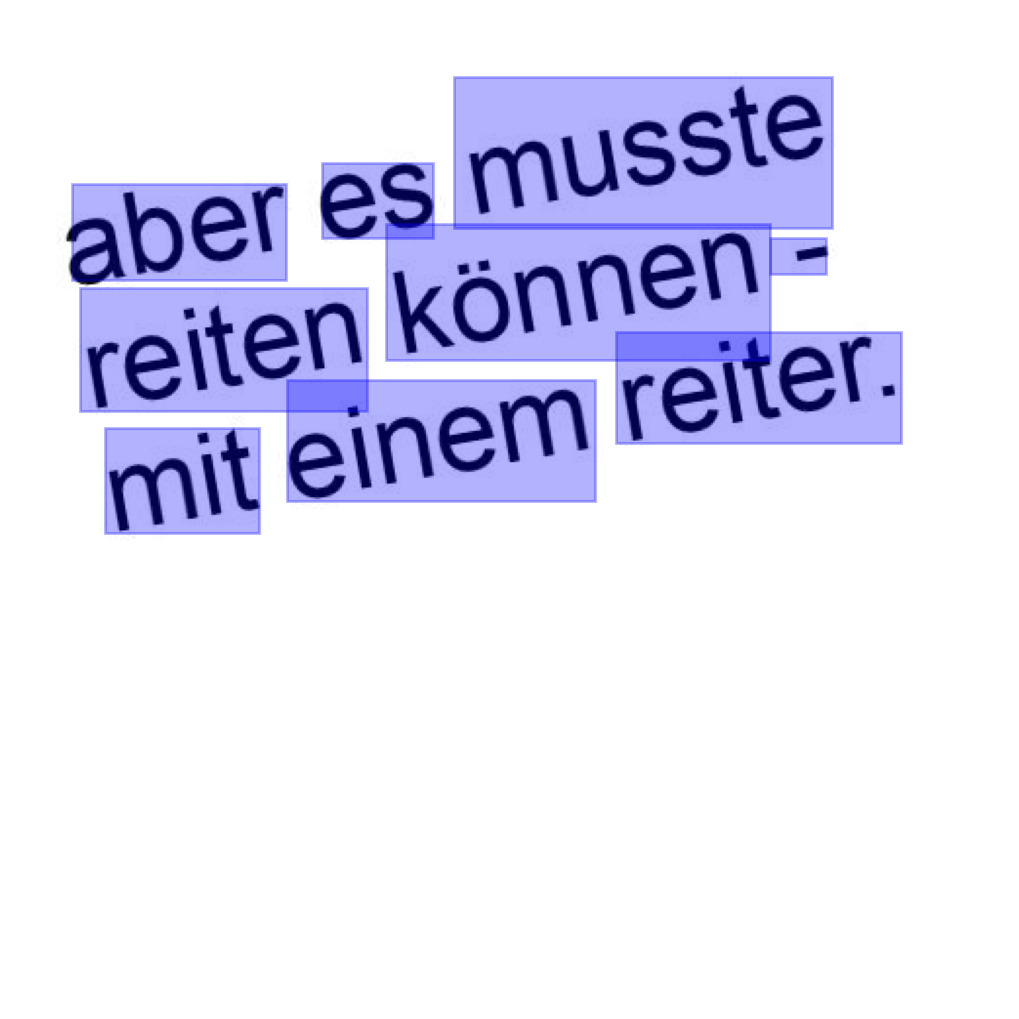

In [6]:
result.show()

Además, si el texto se ha reconocido correctamente, se puede generar el mismo documento:

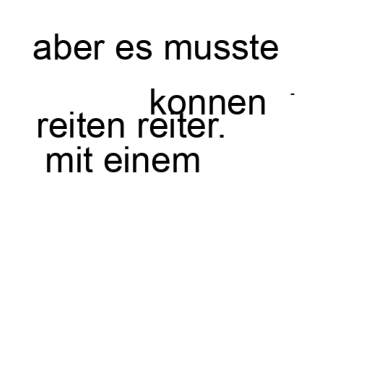

In [7]:
synthetic_pages = result.synthesize(font_family='arial.ttf')  
plt.imshow(synthetic_pages[0]); plt.axis('off'); plt.show()

### Visualización del objeto

Aqui se puede ver como las palabras se han organizado en lineas y estas en bloques, que deberian corresponder a los párrafos en un texto.

In [8]:
print(result)

Document(
  (pages): [Page(
    dimensions=(512, 512)
    (blocks): [
      Block(
        (lines): [
          Line(
            (words): [
              Word(value='aber', confidence=1.0),
              Word(value='es', confidence=0.95),
              Word(value='musste', confidence=1.0),
            ]
          ),
          Line(
            (words): [
              Word(value='reiten', confidence=1.0),
              Word(value='reiter.', confidence=1.0),
            ]
          ),
          Line(
            (words): [
              Word(value='mit', confidence=0.5),
              Word(value='einem', confidence=1.0),
            ]
          ),
        ]
        (artefacts): []
      ),
      Block(
        (lines): [Line(
          (words): [
            Word(value='konnen', confidence=0.56),
            Word(value='-', confidence=0.61),
          ]
        )]
        (artefacts): []
      ),
    ]
  )]
)


## Exportar los resultados

Estos datos se pueden exportar tanto en JSON como en texto plano:

In [9]:
# JSON export
json_export = result.export()
print(json_export)

{'pages': [{'page_idx': 0, 'dimensions': (512, 512), 'orientation': {'value': None, 'confidence': None}, 'language': {'value': None, 'confidence': None}, 'blocks': [{'geometry': ((np.float64(0.060546875), np.float64(0.0673828125)), (np.float64(0.8896484375), np.float64(0.5234375))), 'objectness_score': 0.6243100379194532, 'lines': [{'geometry': ((np.float64(0.060546875), np.float64(0.0673828125)), (np.float64(0.8212890625), np.float64(0.26953125))), 'objectness_score': 0.6138251920541128, 'words': [{'value': 'aber', 'confidence': 0.9987475872039795, 'geometry': ((np.float64(0.060546875), np.float64(0.173828125)), (np.float64(0.275390625), np.float64(0.26953125))), 'objectness_score': 0.667521595954895, 'crop_orientation': {'value': 0, 'confidence': None}}, {'value': 'es', 'confidence': 0.9474281072616577, 'geometry': ((np.float64(0.310546875), np.float64(0.1533203125)), (np.float64(0.421875), np.float64(0.228515625))), 'objectness_score': 0.7445672154426575, 'crop_orientation': {'value

O en texto plano:

In [10]:
# Render the result to a string
string_result = result.render()
print(string_result)

aber es musste
reiten reiter.
mit einem

konnen -
